In [1]:
#Do install apoc and graphdatascience packages in neo4j and neo4j, py2neo and matplotlib before running this notebook
#and set apoc.export.file.enabled=true in your apoc.conf
#importing required packages

from neo4j import GraphDatabase
from py2neo import Graph
from py2neo.data import Node, Relationship
import pandas as pd

In [29]:
#creating driver to connect to Neo4j
url = "bolt://localhost:7687"
username = "neo4j"
password = "anujbansal"

driver = GraphDatabase.driver(url, auth = (username,password))

In [30]:
#function to run cypher queries
def run_cypher_query(query):
    with driver.session() as session:
        result = session.run(query)
        return result.data()

For our usecase we are using the North Carolina 5 million data, provided by "Database Group Leipzig" for Entity Resolution Benchmarking at the following link:
https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution
Dataset charaterstics:\
A. 5 Sources each having voters' data like - name, surname, subrub and pincode\
B. For our use case we are using the 20,000 records from each source i.e. 100,000 records in total\
C. Each source is duplicate free but shares duplicates from other sources with the synthetically corrupted entity data\
D. Out of 100000 records, 75217(~75%) records are unique entities and 24783 (25%) records are duplicate records\

In [25]:
#EDA in Python
input_csv_path = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_0_nump_5.csv"
df = pd.read_csv(input_csv_path, nrows = 20000)
df["source"]= 0
input_csv_path1 = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_1_nump_5.csv"
df1 = pd.read_csv(input_csv_path1, nrows = 20000)
df1["source"]= 1
input_csv_path2 = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_2_nump_5.csv"
df2 = pd.read_csv(input_csv_path2, nrows = 20000)
df2["source"]= 2
input_csv_path3 = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_3_nump_5.csv"
df3 = pd.read_csv(input_csv_path3, nrows = 20000)
df3["source"]= 3
input_csv_path4 = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_4_nump_5.csv"
df4 = pd.read_csv(input_csv_path4, nrows = 20000)
df4["source"]= 4

# List of DataFrames
dfs = [df,df1, df2, df3, df4]
# Concatenate the DataFrames
df_combined = pd.concat(dfs, ignore_index=True)
print(df_combined.head())
print(df_combined[df_combined["recid"].isin([878723,101994])].sort_values(by=['recid']))

     recid givenname   surname         suburb postcode  source
0  7852009   kadelyn  gragnani         waxhaw    28|73       0
1  3138435     ronel    carter     washington    2788g       0
2  6117295     jason   roehrig  millers ceeek    286s1       0
3  6401695    antrea      mure     greensboro    27410       0
4  5202204    caedar    oliver   jacksonville    28542       0
        recid givenname      surname        suburb postcode  source
5168   101994     norma  strawl>erry     high poit    27260       0
25214  101994     norma   strawberry    high piont    27210       1
45203  101994      norm   strawberry    high poknt    27260       2
65214  101994     norma   strawbe5ry    high ppint    27260       3
85237  101994     norma   strawbe5ry    hihh point    27260       4
19660  878723   edwarzd       brooks  fayetteviile    28304       0
39656  878723    edward       brookd  fayetteville    283o4       1
59732  878723   edwarcl       brooks   fayettevile    28304       2
79777  878

In [38]:
print(df_combined["source"].value_counts())
print("\n Number of duplicate values in 'recid' column:", df_combined["recid"].duplicated().sum())
print("\n Number of unique values in 'recid' column:", df_combined["recid"].nunique())
print("\n Number of unique values in 'recid' column in source categories:", df_combined.groupby("source")["recid"].nunique())


source
0    20000
1    20000
2    20000
3    20000
4    20000
Name: count, dtype: int64

 Number of duplicate values in 'recid' column: 24783

 Number of unique values in 'recid' column: 75217

 Number of unique values in 'recid' column in source categories: source
0    20000
1    20000
2    20000
3    20000
4    20000
Name: recid, dtype: int64


In [29]:
print(df_combined.isnull().sum())

recid         0
givenname    15
surname       2
suburb        3
postcode      6
source        0
dtype: int64


In [39]:
#cleaning the cypher database

query = """
    Match(n) Detach Delete n;
"""
results = run_cypher_query(query)

Each of the source file is getting loaded and cleaned in Neo4j database. Along with loading and cleaning, each record is used to create a node and attributes such as surname, givennamem suburb and postcode are used to create node properites after data cleaning (removal of special characters, changing of case, removal of digits from names etc.). In addition few more properties are derived:
1. Source : SourceKey to identify the source from which record is being loaded
2. MatchKey: Prefix of size 2 of surname
3. prefie of size of 2 of givenname

Here is a snapshot of data after these steps:
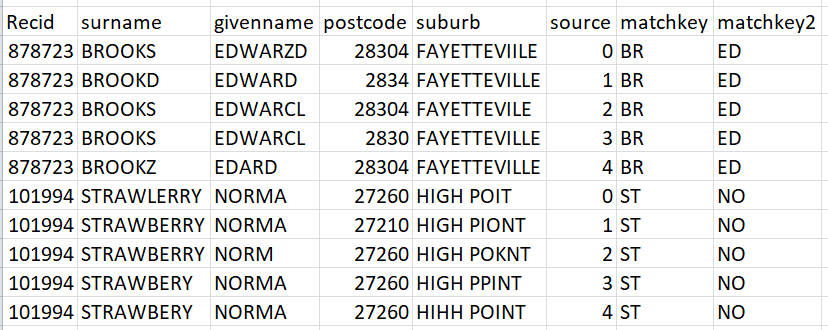

In [41]:
#Loading and cleaning the data file 0 in neo4j

query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_0_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 0,
x.matchkey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.matchkey2 = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2);"""
results = run_cypher_query(query)


In [42]:
#Loading the data file 1 in neo4j
query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_1_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 1,
x.matchkey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.matchkey2 = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2);"""
results = run_cypher_query(query)

In [43]:
#Loading the data file 2 in neo4j
query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_2_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 2,
x.matchkey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.matchkey2 = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2);"""
results = run_cypher_query(query)

In [44]:
#Loading the data file 3 in neo4j
query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_3_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 3,
x.matchkey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.matchkey2 = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2);"""
results = run_cypher_query(query)

In [45]:
#Loading the data file 4 in neo4j
query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_4_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 4,
x.matchkey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.matchkey2 = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2);"""
results = run_cypher_query(query)

Here is an example of a sub-graph of 15 nodes with properties:
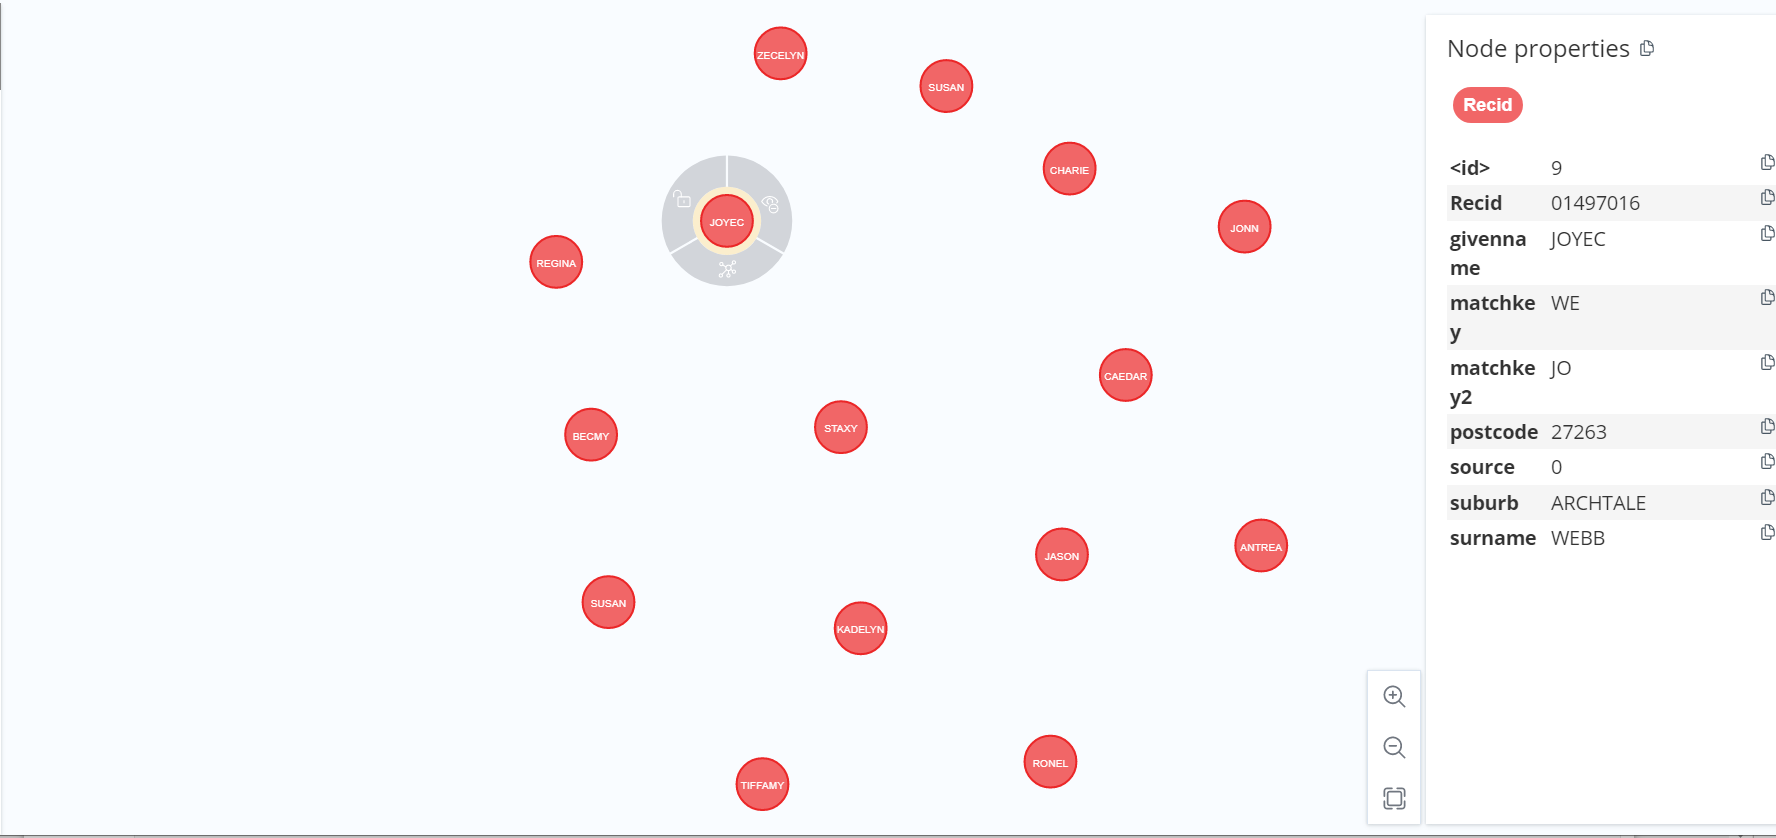

# Workflow

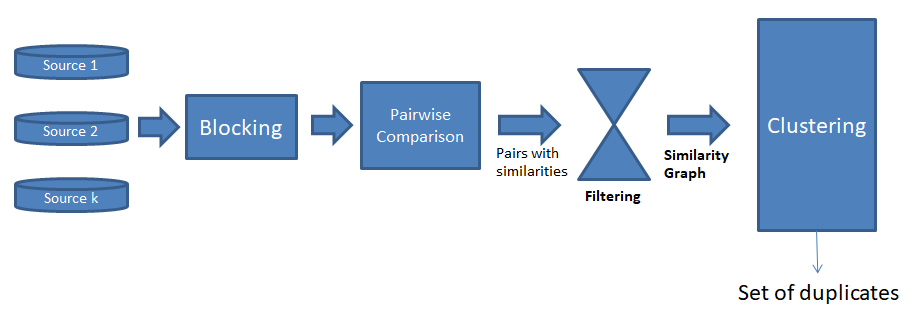

# Data Input
Multiple distinct data sources contain the entities to be matched and grouped. It's worth noting that all sources have been ensured to be free of duplicates.

# Blocking Strategy
To optimize the comparison process and minimize redundant computations, a blocking approach is employed. Instead of naively comparing each entity from one data source against all entities from another source, the entities are divided into groups or "blocks" using predefined attributes. This ensures that only entities with identical blocking attributes need to be compared. The blocking process is executed in two concurrent phases for improved efficiency:

1. **Phase A:** The initial two letters of surnames are used as the first blocking key. Blocks with more than one record are created, and entities within these blocks are compared.
2. **Phase B:** For pairs not covered in Phase A, the initial two letters of given names are used as the second blocking key. Similar to Phase A, blocks with more than one record are formed, and entity pairs within these blocks are compared.

# Pairwise Comparison
Within each block originating from any input data source, all entities undergo pairwise comparison. The similarity of attribute valueeach pairs is similarity score.ty scores.

# Filtering Process
To determine pairs that are likely matches, a filtering step is introduced. This involves applying predetermined threshold values (established through multiple iterations) to the similarity scores. Pairs with similarity scores exceeding these thresholds are identified.

# Similarity Graph Construction
For the pairs that pass through the filtering stage, a similarity graph is constructed. Edges between vertices are c reated, with the similarity scores serving as the properties of these edges.

# Clustering Phase
This step focuses on the aggregation of related vertices within the similarity graph. Vertices that are deemed matching r using theare grouped togethe edges a propertes.
ues.
s syr.e..



In [68]:
phaseA = """
   //Pre-fix blocking with selecting records from different sources as we assume that each source dont have duplicates
MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.matchkey = b.matchkey 

//calculating similarities using jaroWinklerDistance
WITH *, toInteger(100 - apoc.text.jaroWinklerDistance(a.givenname,b.givenname)*100) AS sim1,
toInteger(100 - apoc.text.jaroWinklerDistance(a.surname,b.surname)*100) AS sim2,
toInteger(100- apoc.text.jaroWinklerDistance(a.suburb,b.suburb)*100) AS sim3,
toInteger(100 - apoc.text.jaroWinklerDistance(a.postcode,b.postcode)*100) AS sim4
//filetring based on threshold
WHERE sim1> 85 and sim2>85 and sim3>65 and sim4>65
//creating relationships for identified after threshold
MERGE (a)-[r:similar{sim1:sim1,sim2:sim2,sim3:sim3,sim4:sim4}]-(b)
"""

phaseB =  """
//Pre-fix blocking with selecting records from different sources as we assume that each source dont have duplicates
MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.matchkey <> b.matchkey and a.matchkey2 = b.matchkey2

//calculating similarities using jaroWinklerDistance
WITH *, toInteger(100 - apoc.text.jaroWinklerDistance(a.givenname,b.givenname)*100) AS sim1,
toInteger(100 - apoc.text.jaroWinklerDistance(a.surname,b.surname)*100) AS sim2,
toInteger(100- apoc.text.jaroWinklerDistance(a.suburb,b.suburb)*100) AS sim3,
toInteger(100 - apoc.text.jaroWinklerDistance(a.postcode,b.postcode)*100) AS sim4
//filetring based on threshold
WHERE sim1> 85 and sim2>85 and sim3>65 and sim4>65
//creating relationships for identified after threshold
MERGE (a)-[r:similar{sim1:sim1,sim2:sim2,sim3:sim3,sim4:sim4}]-(b)
"""



In [69]:

def main():
    with GraphDatabase.driver(url, auth = (username,password)) as driver:
        similarity_scores(driver)

def similarity_scores(driver):
   

    # Session a
    with driver.session(database="neo4j") as session_a:
        session_a.run(phaseA) 

    # Session b
    with driver.session(database="neo4j") as session_b:
        session_b.run(phaseB)

if __name__ == "__main__":
    %time main()
    



CPU times: total: 15.6 ms
Wall time: 16min 33s


After blocking, similarity score calculations and filerting, selected pairs of entities are linked together with similarity scores forming the property of edges
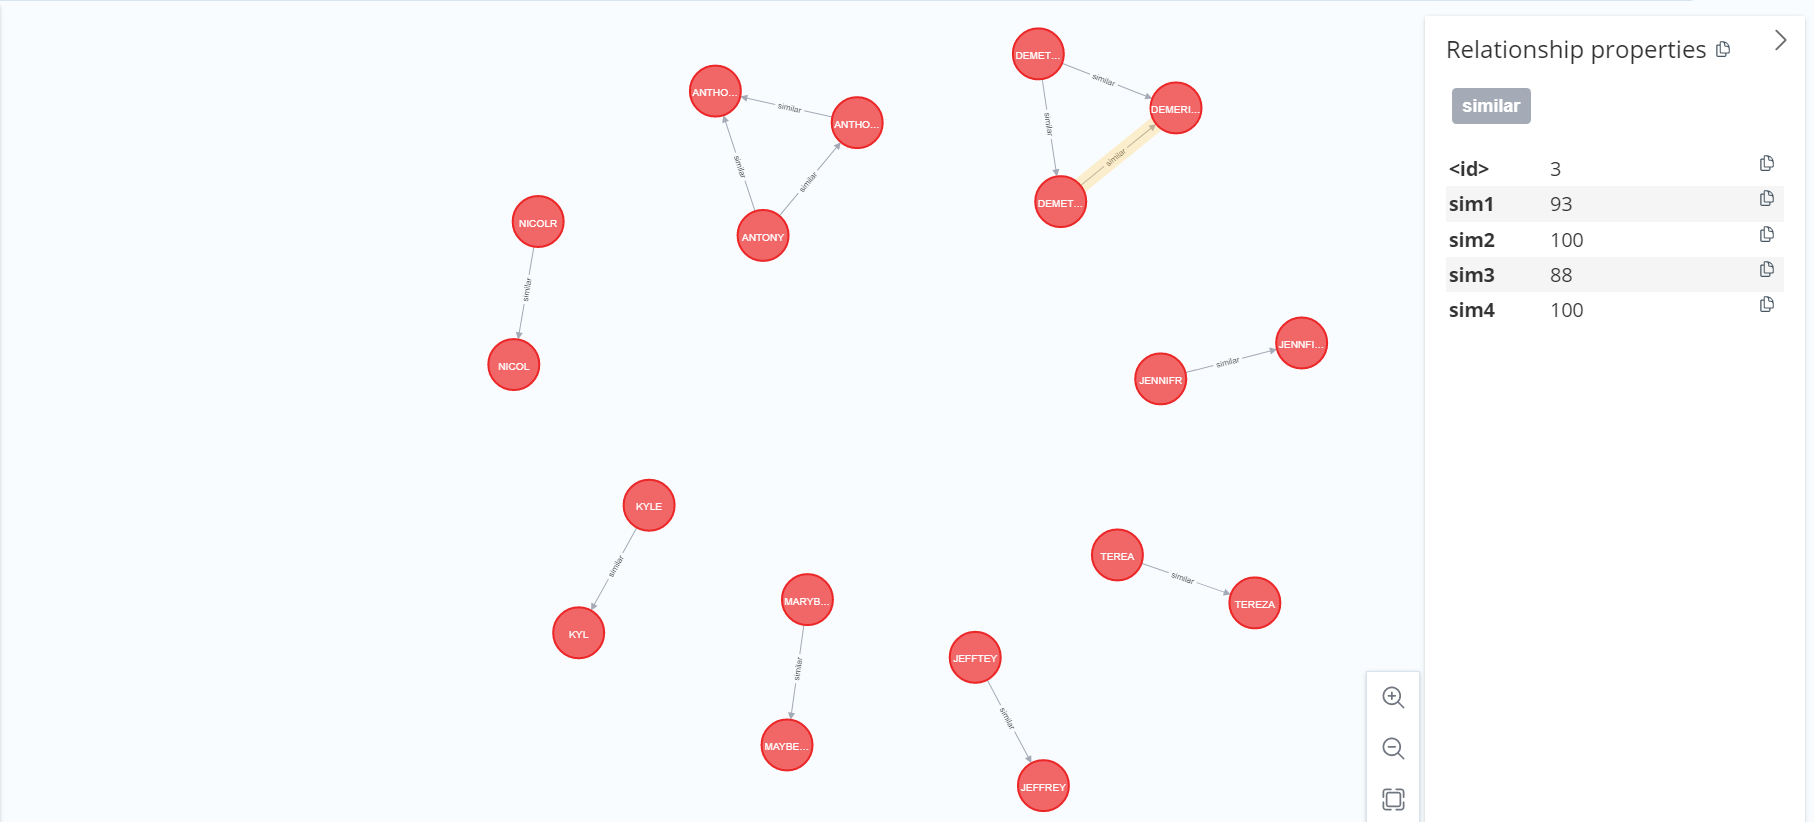

In [72]:
query ="""CALL gds.graph.drop('mygraph2', false) YIELD graphName;"""
results = run_cypher_query(query)

In [73]:
#graph creation in neo4j
query = """
CALL gds.graph.project(
	'mygraph2',
	'Recid',
	{
	similar:{
	orientation:'UNDIRECTED',
	properties:['sim1','sim2','sim3','sim4']
	}
	}
)
"""
results = run_cypher_query(query)

In [74]:
#entity resolution in neo4j
query = """
CALL gds.labelPropagation.write('mygraph2', { writeProperty: 'community' }) YIELD communityCount, ranIterations, didConverge
"""
results = run_cypher_query(query)

Here is an example how communities are assigned to entities similar to each other:

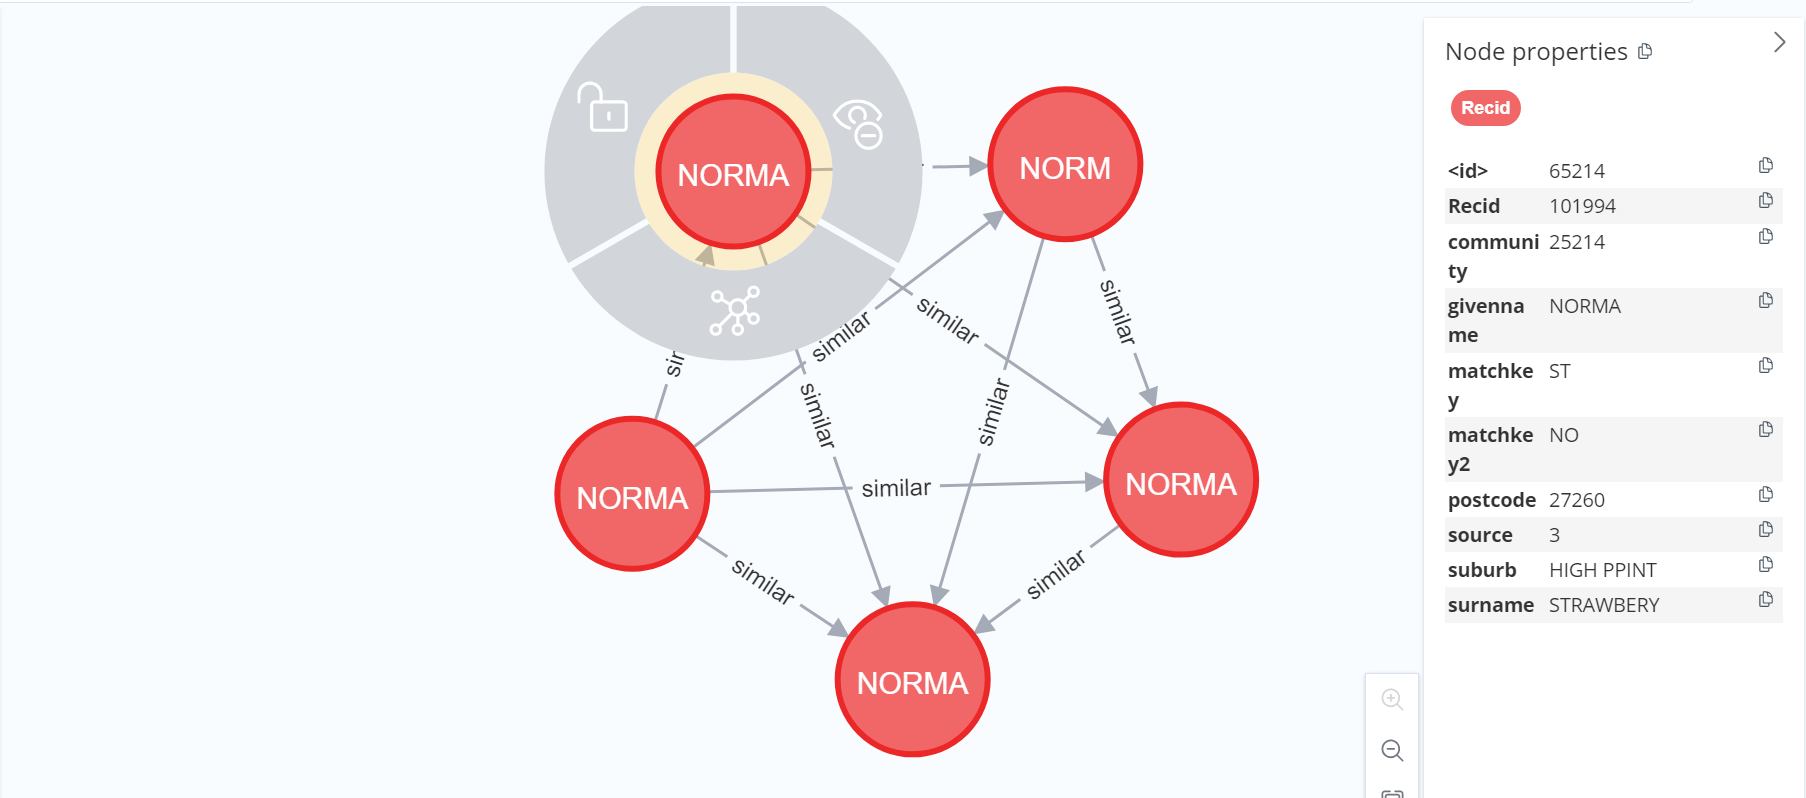

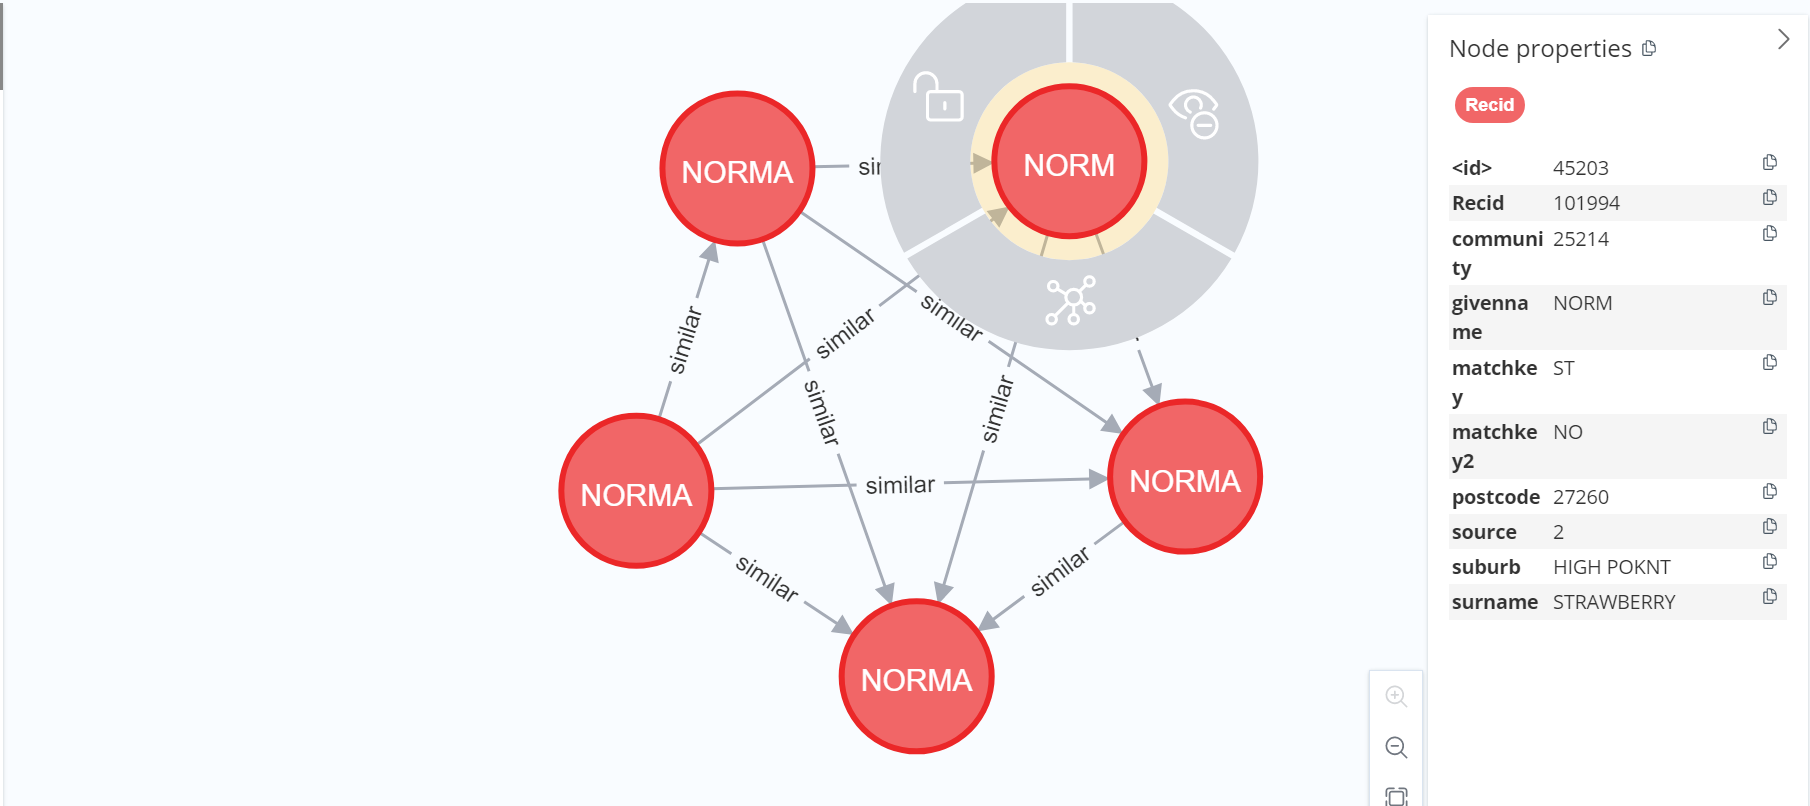

Here is how the data look like when exported in a csv format, Community id is a model generated id identifying the set of duplicate entities:
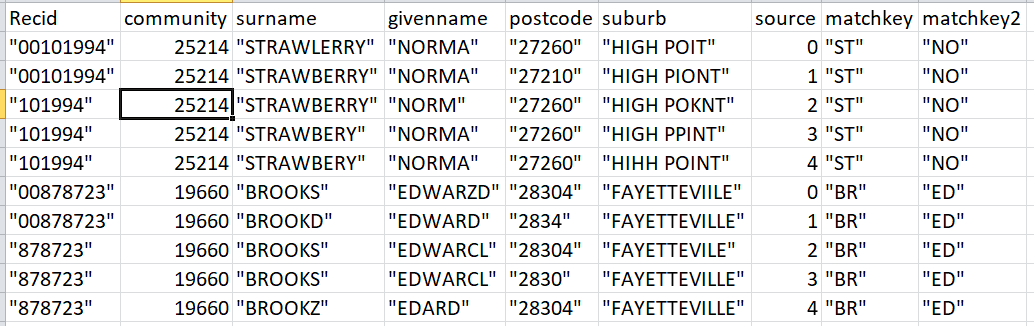

In [75]:
#exporting the output
query ="""
call apoc.export.csv.query("Match(n) Return n.Recid as Recid, n.community as community, n.surname as surname, n.givenname as givenname,n.postcode as postcode,n.suburb as suburb,n.source as source,n.matchkey as matchkey,n.matchkey2 as matchkey2","export2.csv",{})
"""
results = run_cypher_query(query)

In [25]:
driver.close()

In [79]:
csv_path = r"C:\Users\lenovo\Downloads\export.csv"
df = pd.read_csv(csv_path)
print(df.head)

<bound method NDFrame.head of             Recid  community     surname  givenname postcode           suburb  \
0      "07852009"          0  "GRAGNANI"  "KADELYN"   "2873"         "WAXHAW"   
1      "03138435"          1    "CARTER"    "RONEL"   "2788"     "WASHINGTON"   
2      "06117295"          2   "ROEHRIG"    "JASON"   "2861"  "MILLERS CEEEK"   
3      "06401695"          3      "MURE"   "ANTREA"  "27410"     "GREENSBORO"   
4      "05202204"      40002    "OLIVER"   "CAEDAR"  "28542"   "JACKSONVILLE"   
...           ...        ...         ...        ...      ...              ...   
99995   "6200144"      99995    "LARSON"  "BARBATA"   "2831"   "FAYETTEVILLE"   
99996   "3983781"      99996    "LAUREL"  "JANEQTE"  "27408"     "GREENSBORO"   
99997   "7165975"      99997  "ATKINSON"    "LOGAN"  "28447"       "CALABSSH"   
99998    "969491"      99998      "ALLN"  "CHESTER"  "27705"         "DUHRAM"   
99999   "4026584"      99999    "MURJAY"  "TIFFAAY"  "27615"        "RALEIGH"  

In [80]:
df['Recid'] =pd.to_numeric(df['Recid'].str.replace('"',''))
print(df.head)

<bound method NDFrame.head of          Recid  community     surname  givenname postcode           suburb  \
0      7852009          0  "GRAGNANI"  "KADELYN"   "2873"         "WAXHAW"   
1      3138435          1    "CARTER"    "RONEL"   "2788"     "WASHINGTON"   
2      6117295          2   "ROEHRIG"    "JASON"   "2861"  "MILLERS CEEEK"   
3      6401695          3      "MURE"   "ANTREA"  "27410"     "GREENSBORO"   
4      5202204      40002    "OLIVER"   "CAEDAR"  "28542"   "JACKSONVILLE"   
...        ...        ...         ...        ...      ...              ...   
99995  6200144      99995    "LARSON"  "BARBATA"   "2831"   "FAYETTEVILLE"   
99996  3983781      99996    "LAUREL"  "JANEQTE"  "27408"     "GREENSBORO"   
99997  7165975      99997  "ATKINSON"    "LOGAN"  "28447"       "CALABSSH"   
99998   969491      99998      "ALLN"  "CHESTER"  "27705"         "DUHRAM"   
99999  4026584      99999    "MURJAY"  "TIFFAAY"  "27615"        "RALEIGH"   

       source matchkey matchkey2 

In [92]:
df = df.sort_values(by=['Recid', 'community'])
df['community_wRecid_Primary'] = df.groupby('Recid')['community'].shift(1)
df['False_Negative_Flag'] = df.apply(lambda row: 0 if pd.isna(row['community_wRecid_Primary']) else (0 if row['community_wRecid_Primary'] == row['community'] else 1), axis=1)
df = df.sort_values(by=['Recid', 'community'])
df['Recid_wcommunity_Primary'] = df.groupby('community')['Recid'].shift(1)
df['False_Positive_Flag'] = df.apply(lambda row: 0 if pd.isna(row['Recid_wcommunity_Primary']) else (0 if row['Recid_wcommunity_Primary'] == row['Recid'] else 1), axis=1)


print(df[df['Recid']==2073])
print("False Negatives:" , df['False_Negative_Flag'].sum())
print("False Positives:" , df['False_Positive_Flag'].sum())

       Recid  community   surname givenname postcode         suburb  source  \
31081   2073      31081  "DAYLOR"  "JARIET"  "27869"  "RICH SQUARE"       1   
71107   2073      71107  "TAYLOR"   "JANED"   "2786"  "RICH SQUARE"       3   

      matchkey matchkey2  lag_Recid_wRecid_Primary  community_wRecid_Primary  \
31081     "DA"      "JA"                       NaN                       NaN   
71107     "TA"      "JA"                   31081.0                   31081.0   

       False_Negative_Flag  Recid_wcommunity_Primary  False_Positive_Flag  
31081                    0                       NaN                    0  
71107                    1                       NaN                    0  
False Negatives: 5212
False Positives: 552


Out of 24783 actual duplicate records, model is correctly able to identify 19571 (~79%) duplicate records. And 552 records identified as duplicates by model are false positives with a false positive rate of 3%. End to End runtime for 100,000 records is around ~19 minutes.
